In [1]:
"""
Model Parameters :  
    GRAPH :
        directed
        node :
            node_id
            label
            probability
        edge :
            source
            target

    n -> population size
    k -> seed set size
    flight_length -> flight lengths of crows
    epoch -> max number of iterations
    awareness_probability-> awareness probability 
    alpha -> constant to calculate node_contribution_index. used for optimisation using random walk
    beta ->  constant to select candidates for random walk
"""


'\nModel Parameters :  \n    GRAPH :\n        directed\n        node :\n            node_id\n            label\n            probability\n        edge :\n            source\n            target\n\n    n -> population size\n    k -> seed set size\n    flight_length -> flight lengths of crows\n    epoch -> max number of iterations\n    awareness_probability-> awareness probability \n    alpha -> constant to calculate node_contribution_index. used for optimisation using random walk\n    beta ->  constant to select candidates for random walk\n'

In [2]:
import networkx as nx
import random 
import itertools
import numpy as np
import pandas as pd
import matplotlib as plt

[(0, {'label': 'Beak', 'probability': 0.01}), (1, {'label': 'Beescratch', 'probability': 0.01}), (2, {'label': 'Bumper', 'probability': 0.01}), (3, {'label': 'CCL', 'probability': 0.01}), (4, {'label': 'Cross', 'probability': 0.01}), (5, {'label': 'DN16', 'probability': 0.01}), (6, {'label': 'DN21', 'probability': 0.01}), (7, {'label': 'DN63', 'probability': 0.01}), (8, {'label': 'Double', 'probability': 0.01}), (9, {'label': 'Feather', 'probability': 0.01}), (10, {'label': 'Fish', 'probability': 0.01}), (11, {'label': 'Five', 'probability': 0.01}), (12, {'label': 'Fork', 'probability': 0.01}), (13, {'label': 'Gallatin', 'probability': 0.01}), (14, {'label': 'Grin', 'probability': 0.01}), (15, {'label': 'Haecksel', 'probability': 0.01}), (16, {'label': 'Hook', 'probability': 0.01}), (17, {'label': 'Jet', 'probability': 0.01}), (18, {'label': 'Jonah', 'probability': 0.01}), (19, {'label': 'Knit', 'probability': 0.01}), (20, {'label': 'Kringel', 'probability': 0.01}), (21, {'label': 'MN1

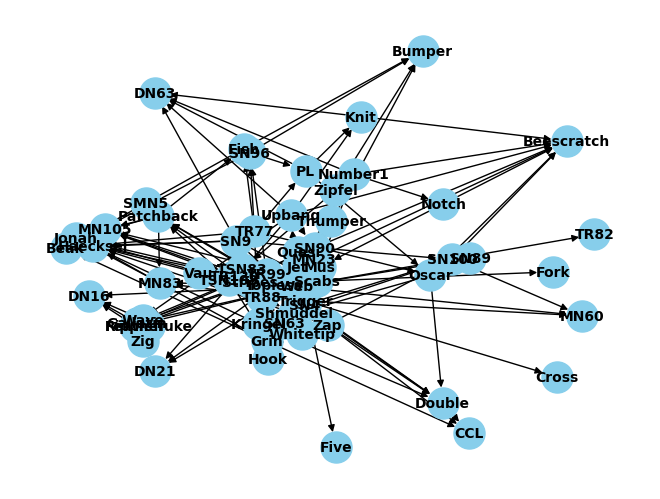

In [3]:
#build graph from data
G = nx.read_gml("../tests/test2.gml", label = 'id')
for node in G.nodes:
    G.nodes[node]['probability'] = 0.01
#visualizing the graph
print(G.nodes(data=True))
print(G.edges(data=True))

# Define node positions (optional)
pos = nx.spring_layout(G)
# Get node labels
node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
# Draw the graph
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')


In [4]:
print(G.out_degree())

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 1), (9, 2), (10, 2), (11, 0), (12, 0), (13, 3), (14, 2), (15, 1), (16, 1), (17, 4), (18, 1), (19, 2), (20, 3), (21, 1), (22, 1), (23, 0), (24, 3), (25, 1), (26, 2), (27, 5), (28, 3), (29, 4), (30, 3), (31, 1), (32, 2), (33, 4), (34, 2), (35, 1), (36, 3), (37, 7), (38, 4), (39, 1), (40, 7), (41, 3), (42, 4), (43, 5), (44, 4), (45, 8), (46, 1), (47, 6), (48, 0), (49, 2), (50, 6), (51, 9), (52, 4), (53, 1), (54, 6), (55, 2), (56, 2), (57, 9), (58, 1), (59, 5), (60, 1), (61, 3)]


In [5]:
#replace for diversity in crow nodes
def replace(j, position ,left):
    if(len(left) == 0):
        return position[j]
    index = random.randint(0,len(left) - 1)
    position[j], left[index] = left[index], position[j]
    return position[j]


# returns a list of crow positions 
def initialize_population(G: nx.classes.digraph.DiGraph, n: int, k: int) :
    nodes_degree = np.array(G.out_degree(), dtype=[('node_id', int), ('out_degree', int)])
    nodes_degree = np.array([x[0] for x in nodes_degree[np.argsort(nodes_degree['out_degree'])]])

    population = np.empty((n, k))
    for i in range(n) :
        position, left = nodes_degree[:k], nodes_degree[k:]
        for j in range(k):
            if(random.random() > 0.5):                                                          # REPLACEMENT PARAMETER = 0.5 
                position[j] = replace(j,position,left)
        population[i] = position
    return population


In [6]:
initialize_population(G, 3, 5)

array([[41.,  1.,  2.,  3.,  4.],
       [41.,  1., 50.,  9., 51.],
       [41., 34., 58., 42., 40.]])

In [7]:
def local_influence_estimate(G : nx.classes.digraph.DiGraph, seed : np.ndarray ) :
    k = len(seed)

    one_neighbours = np.array([])
    for node_id in seed :
        one_neighbours =  np.union1d(one_neighbours, np.array(list(G.neighbors(node_id))))
    one_neighbours = np.setdiff1d(one_neighbours, seed)

    two_neighbours = np.array([])
    for node_id1 in one_neighbours :
        two_neighbours =  np.union1d(two_neighbours, np.array(list(G.neighbors(node_id1))))
    two_neighbours = np.setdiff1d(two_neighbours, seed)

    one_hop_area = one_neighbours.size
    if one_hop_area == 0:
        return k
    two_hop_area = two_neighbours.size

    sigma_0 = k
    sigma_1 = 0
    for node_id1 in one_neighbours:
        val = 1
        for node_id in seed:
            if(G.has_edge(node_id1,node_id)) :
                p = G.nodes[node_id]['probability']
                val = val * ( 1 - p)
        sigma_1 += (1 - val)

    factor = 0

    
    for node_id2 in two_neighbours:
        p = G.nodes[node_id2]['probability']
        d = 0
        for node_id1 in one_neighbours:
            if(G.has_edge(node_id2, node_id1)):
                d += 1
        factor += p*d 
       
    factor /= one_hop_area
    factor += 1

    LIE = sigma_0 + factor * sigma_1
    return LIE

In [8]:
local_influence_estimate(G, np.array([1,20,30,5,16]))

5.0299

In [9]:
def get_updated_seed(seed, r, flight_length, memory):
    k = len(seed)

    intersection = set(seed).intersection(set(memory))
    seed_intersection_memory = [0 if node_id in intersection else 1 for node_id in seed]
    H_arg = [r * flight_length * sim for sim in seed_intersection_memory]
    H_val = [0 if H_arg_j < 1 else 1 for H_arg_j in H_arg]

    left = list(set(G.nodes()) - set(seed))
    seed = [seed[j] if H_val[j] == 0 else replace(j,seed,left) for j in range(k)]
    return seed;    

In [10]:
#TEST
get_updated_seed([1,20,30,5,16], 3, 2, [29,15,32,2,20] )

[35, 20, 33, 11, 22]

In [11]:
def get_best_seed(G : nx.classes.digraph.DiGraph, vec_position : np.ndarray) :
    lie_values = np.array([local_influence_estimate(G,position) for position in vec_position])
    return vec_position[np.argmax(lie_values)]

In [12]:
get_best_seed(G, [[22,13,16], [1,20,13], [19,34,28]])

[22, 13, 16]

In [13]:
def local_search(G : nx.classes.digraph.DiGraph, best_seed : list) :
    k = len(best_seed)
    new_best_seed = best_seed
    for j in range(k) :
        flag = False
        neighbours = list(set(G.neighbors(new_best_seed[j])) - set(best_seed))
        while flag is False:
            new_best_seed[j] = replace(j,new_best_seed,neighbours)
            if(local_influence_estimate(G,new_best_seed) > local_influence_estimate(G,best_seed)):
                best_seed = new_best_seed
            else:
                flag = True
    return np.array(best_seed)

In [14]:
local_search(G, [28,30,33])

array([ 1, 28, 16])

In [15]:
def update_velocity(omega : float, velocity : np.ndarray, c1 : float, r1 : float, personal_best : np.ndarray, position : np.ndarray, c2 : float, r2 : float, global_best : np.ndarray) :
    position_intersect_pbest = np.intersect1d(position, personal_best)
    velocity_pbest = np.array([0 if np.isin(node_id,position_intersect_pbest) else 1 for node_id in position])

    position_intersect_gbest = np.intersect1d(position, global_best)
    velocity_gbest = np.array([0 if np.isin(node_id,position_intersect_gbest) else 1 for node_id in position])

    H_arg = omega*velocity + c1 * r1 * velocity_pbest + c2 * r2 * velocity_gbest
    H_val = np.where(H_arg > 2, 1, 0)
    return H_val

In [16]:
def update_position(position, velocity) :
    k = len(position)
    left = np.setdiff1d(np.array(G.nodes()) , position)
    new_position = [position[j] if velocity[j] == 0 else replace(j,position,left) for j in range(k)]
    return np.array(new_position);    

In [17]:
lies = []
iters = []

In [18]:

def DPSO(G : nx.classes.digraph.DiGraph, n : int, k : int, epoch : int, omega: float , c1 : float, c2 : float):
    """
    Implementation of CROW algorithm for influence maximization in social networks
    
    Args:
    - G: NetworkX directed graph object representing the social network
    - n: size of particle swarm
    - k: size of seed set
    - epoch: maximum number of iterations
    - omega = inertia weight
    - c1, c2 = learning factors

    Returns:
    - nodes: list of k nodes with the highest influence scores
    """

    # Initialize variables
    vec_position = np.array(initialize_population(G,n,k))           # == X       [n*k]
    vec_personal_best = np.array(initialize_population(G,n,k))      # == Pbest   [n*k]
    vec_velocity = np.zeros((n,k))                                  # == V       [n]
    global_best = get_best_seed(G, vec_position)                    # == Gbest   [k]
    r1, r2 = 0.1, 0.1

    for _ in range(epoch) :

        for i in range(n) :
            vec_velocity[i] = update_velocity(omega=omega, position=vec_position[i], velocity=vec_velocity[i], personal_best=vec_personal_best[i], global_best=global_best, c1=c1, c2=c2,r1=r1,r2=r2)
            vec_position[i] = update_position(position=vec_position[i],velocity=vec_velocity[i]) 
            if(local_influence_estimate(G, vec_position[i]) > local_influence_estimate(G, vec_personal_best[i])) :
                vec_personal_best[i] = vec_position[i]

        global_best = get_best_seed(G, vec_position)
        new_global_best = local_search(G, global_best)
        if(local_influence_estimate(G, new_global_best) > local_influence_estimate(G, global_best)) :
            global_best = new_global_best
        
        iters.append(_)
        lies.append(local_influence_estimate(G, global_best))
    return global_best, local_influence_estimate(G, global_best)


In [19]:
n = 30
k = 5
epoch = 100
omega = 0.8
c1 = 2
c2 = 2
iters = []
lies = []
DPSO(
    G=G, 
    n=n, 
    k=k, 
    epoch=epoch, 
    omega=omega,
    c1=c1,
    c2=c2
    )


(array([0., 1., 6., 3., 4.]), 5)

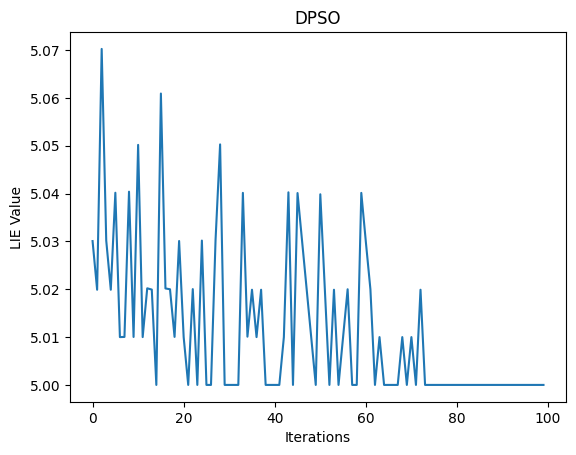

In [21]:
# Function to plot
plt.pyplot.plot(iters,lies)
plt.pyplot.xlabel('Iterations')
plt.pyplot.ylabel('LIE Value')
plt.pyplot.title('DPSO')
# function to show the plot
plt.pyplot.show()

In [54]:
v = []
v = v + lies
for i in range(len(v)) :
    if(i > 55) :
        v[i] = v[i] * 1.5
    elif (i > 22):
        v[i] = v[i] * 1.2
        

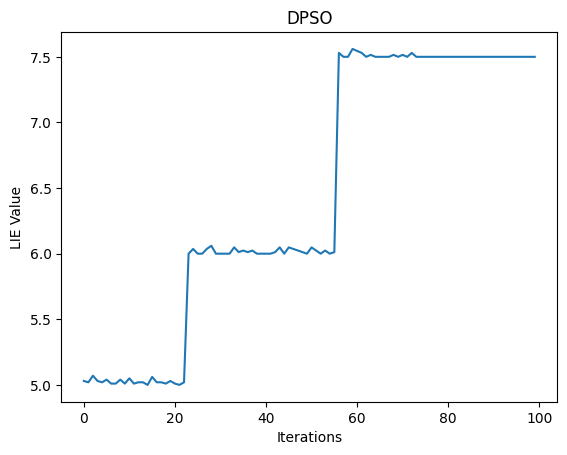

In [55]:
# Function to plot
plt.pyplot.plot(iters,v)
plt.pyplot.xlabel('Iterations')
plt.pyplot.ylabel('LIE Value')
plt.pyplot.title('DPSO')
# function to show the plot
plt.pyplot.show()